
# 🧪 Hacking Class Lab: Brute‑Forcing Caesar (Shift) Ciphers

Welcome to the **Caesar Cipher Brute‑Force Lab**. This notebook is designed for use in **Google Colab** (or locally in Jupyter) for your hacking class session on code breaking with a **Caesar cipher wheel**.

### What you'll learn
- How Caesar/shift ciphers work and how a cipher wheel represents shifts  
- How to brute‑force all 26 keys and **rank** candidates automatically  
- How to use **frequency analysis** & **chi‑square** scoring  
- How to search with a **crib** (a likely plaintext word)  
- How to visualize letter frequencies and reason about results  

> Tip: The cipher wheel maps plaintext letters to ciphertext letters by a fixed rotation (shift). Brute‑forcing tries all 26 possible rotations to recover the message.


## 0) Setup

In [1]:

# No external installs required. Pure-Python helpers below.
from collections import Counter
import math
import re

ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def normalize_text(s):
    """Uppercase and strip accents/punctuation except spaces and digits for easier viewing."""
    s = s.upper()
    # Keep letters, spaces, digits, and basic punctuation for readability
    return re.sub(r"[^A-Z0-9 \-\'\.,;:!?]", "", s)

def caesar_shift_char(ch, k):
    if ch.isalpha():
        base = ord('A')
        return chr((ord(ch) - base + k) % 26 + base)
    return ch

def caesar_encrypt(plaintext, k):
    plaintext = normalize_text(plaintext)
    return ''.join(caesar_shift_char(ch, k) for ch in plaintext)

def caesar_decrypt(ciphertext, k):
    # Decrypt is shift by -k
    return ''.join(caesar_shift_char(ch, -k) for ch in ciphertext)

def brute_force_all_shifts(ciphertext):
    """Return list of (key, plaintext_candidate)."""
    out = []
    for k in range(26):
        out.append((k, caesar_decrypt(ciphertext, k)))
    return out

# A compact, high-signal wordlist for simple scoring (no internet needed).
COMMON_WORDS = set('''
THE OF AND TO IN A IS THAT IT HE WAS FOR ON ARE AS WITH HIS THEY I AT BE
THIS HAVE FROM OR ONE HAD BY WORD BUT NOT WHAT ALL WERE WE WHEN YOUR CAN
SAID THERE USE AN EACH WHICH SHE DO HOW THEIR IF
'''.split())

def english_word_score(text):
    """Score based on how many COMMON_WORDS appear (very rough heuristic)."""
    words = re.findall(r"[A-Z']+", text.upper())
    if not words:
        return 0.0
    hits = sum(1 for w in words if w in COMMON_WORDS)
    return hits / max(1, len(words))

# English letter frequency (percentage) from typical corpora
ENGLISH_FREQ = {
    'A': 8.12, 'B': 1.49, 'C': 2.71, 'D': 4.32, 'E': 12.02, 'F': 2.30,
    'G': 2.03, 'H': 5.92, 'I': 7.31, 'J': 0.10, 'K': 0.69, 'L': 3.98,
    'M': 2.61, 'N': 6.95, 'O': 7.68, 'P': 1.82, 'Q': 0.11, 'R': 6.02,
    'S': 6.28, 'T': 9.10, 'U': 2.88, 'V': 1.11, 'W': 2.09, 'X': 0.17,
    'Y': 2.11, 'Z': 0.07
}

def chi_square_score(text):
    """Lower is better (observed vs expected English letter distribution)."""
    text_only = re.findall(r"[A-Z]", text.upper())
    N = len(text_only)
    if N == 0:
        return float('inf')
    counts = Counter(text_only)
    chi = 0.0
    for letter in ALPHABET:
        observed = counts.get(letter, 0)
        expected = ENGLISH_FREQ[letter] * N / 100.0
        chi += (observed - expected) ** 2 / (expected + 1e-9)  # avoid zero-div
    return chi

def combined_score(text, alpha=0.7):
    """Combine (normalized) chi-square (lower better) and word-score (higher better).
    We invert chi-square so that larger is better; then blend with word-score.
    """
    cs = chi_square_score(text)
    ws = english_word_score(text)
    # Normalize/invert chi-square via a simple transform; add 1 to stabilize
    inv_chi = 1.0 / (1.0 + cs)
    return alpha * inv_chi + (1 - alpha) * ws

print("✔️ Helpers loaded.")


✔️ Helpers loaded.



## 1) How the Caesar wheel maps letters

A Caesar wheel represents a rotation of the alphabet. For a key **k**, each plaintext letter `P` maps to ciphertext letter `C` by:

\[ C = (P + k) \mod 26 \]

Decrypting is the inverse rotation:

\[ P = (C - k) \mod 26 \]

You can experiment with a sample plaintext and key below.


In [9]:

sample_plain = "WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN"
key = 7  # try different shifts 0-25
cipher = caesar_encrypt(sample_plain, key)
decoded = caesar_decrypt(cipher, key)
print("Key:", key)
print("Plain :", sample_plain)
print("Cipher:", cipher)
print("Back  :", decoded)


Key: 7
Plain : WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN
Cipher: DL HYL YLHKF MVY DHY HUK PA PZ APTL FVB ZOVBSK HAAHJR AVTVYYVD HA KHDU
Back  : WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN


## 2) Brute‑force all 26 keys

In [10]:

#ciphertext = "HAAHJR HA KHDU"  # Replace with your cipher text (uppercase letters work best)
ciphertext = cipher
candidates = brute_force_all_shifts(ciphertext)

for k, pt in candidates:
    print(f"k={k:2d} -> {pt}")


k= 0 -> DL HYL YLHKF MVY DHY HUK PA PZ APTL FVB ZOVBSK HAAHJR AVTVYYVD HA KHDU
k= 1 -> CK GXK XKGJE LUX CGX GTJ OZ OY ZOSK EUA YNUARJ GZZGIQ ZUSUXXUC GZ JGCT
k= 2 -> BJ FWJ WJFID KTW BFW FSI NY NX YNRJ DTZ XMTZQI FYYFHP YTRTWWTB FY IFBS
k= 3 -> AI EVI VIEHC JSV AEV ERH MX MW XMQI CSY WLSYPH EXXEGO XSQSVVSA EX HEAR
k= 4 -> ZH DUH UHDGB IRU ZDU DQG LW LV WLPH BRX VKRXOG DWWDFN WRPRUURZ DW GDZQ
k= 5 -> YG CTG TGCFA HQT YCT CPF KV KU VKOG AQW UJQWNF CVVCEM VQOQTTQY CV FCYP
k= 6 -> XF BSF SFBEZ GPS XBS BOE JU JT UJNF ZPV TIPVME BUUBDL UPNPSSPX BU EBXO
k= 7 -> WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN
k= 8 -> VD ZQD QDZCX ENQ VZQ ZMC HS HR SHLD XNT RGNTKC ZSSZBJ SNLNQQNV ZS CZVM
k= 9 -> UC YPC PCYBW DMP UYP YLB GR GQ RGKC WMS QFMSJB YRRYAI RMKMPPMU YR BYUL
k=10 -> TB XOB OBXAV CLO TXO XKA FQ FP QFJB VLR PELRIA XQQXZH QLJLOOLT XQ AXTK
k=11 -> SA WNA NAWZU BKN SWN WJZ EP EO PEIA UKQ ODKQHZ WPPWYG PKIKNNKS WP ZWSJ
k=12 -> RZ VMZ MZVYT AJM RVM VIY DO DN ODHZ TJP NCJP

## 3) Rank candidates by English‑likeness (combined score)

In [11]:

scored = []
for k, pt in candidates:
    score = combined_score(pt, alpha=0.7)
    scored.append((score, k, pt))

scored.sort(reverse=True)  # larger = better
print("Top 10 candidates by score:")
for i, (score, k, pt) in enumerate(scored[:10], 1):
    print(f"{i:2d}. k={k:2d} | score={score:.4f} | {pt[:100]}{'...' if len(pt)>100 else ''}")


Top 10 candidates by score:
 1. k= 7 | score=0.1674 | WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN
 2. k=12 | score=0.0206 | RZ VMZ MZVYT AJM RVM VIY DO DN ODHZ TJP NCJPGY VOOVXF OJHJMMJR VO YVRI
 3. k=19 | score=0.0051 | KS OFS FSORM TCF KOF OBR WH WG HWAS MCI GVCIZR OHHOQY HCACFFCK OH ROKB
 4. k= 9 | score=0.0032 | UC YPC PCYBW DMP UYP YLB GR GQ RGKC WMS QFMSJB YRRYAI RMKMPPMU YR BYUL
 5. k= 0 | score=0.0027 | DL HYL YLHKF MVY DHY HUK PA PZ APTL FVB ZOVBSK HAAHJR AVTVYYVD HA KHDU
 6. k=23 | score=0.0025 | GO KBO BOKNI PYB GKB KXN SD SC DSWO IYE CRYEVN KDDKMU DYWYBBYG KD NKGX
 7. k=18 | score=0.0025 | LT PGT GTPSN UDG LPG PCS XI XH IXBT NDJ HWDJAS PIIPRZ IDBDGGDL PI SPLC
 8. k=14 | score=0.0023 | PX TKX KXTWR YHK PTK TGW BM BL MBFX RHN LAHNEW TMMTVD MHFHKKHP TM WTPG
 9. k=16 | score=0.0016 | NV RIV IVRUP WFI NRI REU ZK ZJ KZDV PFL JYFLCU RKKRTB KFDFIIFN RK URNE
10. k=21 | score=0.0015 | IQ MDQ DQMPK RAD IMD MZP UF UE FUYQ KAG ETAGXP MFFMOW FAYADDAI MF PMIZ


## 4) Use a crib (known word fragment) to filter results

In [12]:

crib = "ATTACK"  # e.g., a word you expect in the plaintext (case-insensitive)
crib_re = re.compile(re.escape(crib), re.IGNORECASE)

filtered = [(k, pt) for (k, pt) in brute_force_all_shifts(ciphertext) if crib_re.search(pt)]
if not filtered:
    print(f"No candidates contain crib '{crib}'. Try a different crib or remove it.")
else:
    for k, pt in filtered:
        print(f"k={k:2d} -> {pt}")


k= 7 -> WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN



## 5) Frequency analysis visualization

Compare the letter frequency of a candidate plaintext against typical English. Lower **chi‑square** generally indicates a closer match.

> If you're in **Colab**, run this cell to see a bar chart.


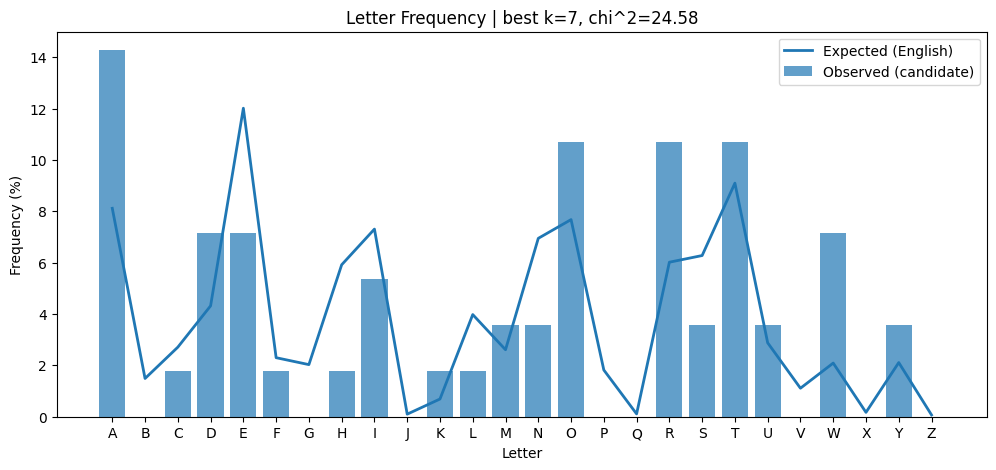

Best candidate preview:
WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN


In [13]:

import matplotlib.pyplot as plt

def letter_freq(text):
    letters = [c for c in text.upper() if c.isalpha()]
    N = len(letters)
    counts = Counter(letters)
    return [100.0 * counts.get(ch, 0)/N if N else 0.0 for ch in ALPHABET]

# Pick the top-scoring candidate
best_score, best_k, best_pt = scored[0]
obs = letter_freq(best_pt)
exp = [ENGLISH_FREQ[ch] for ch in ALPHABET]

plt.figure(figsize=(12,5))
plt.bar(range(26), obs, alpha=0.7, label="Observed (candidate)")
plt.plot(range(26), exp, linewidth=2, label="Expected (English)")
plt.xticks(range(26), list(ALPHABET))
plt.title(f"Letter Frequency | best k={best_k}, chi^2={chi_square_score(best_pt):.2f}")
plt.xlabel("Letter")
plt.ylabel("Frequency (%)")
plt.legend()
plt.show()

print("Best candidate preview:")
print(best_pt[:500])


## 6) Bonus: auto‑detect best key

In [14]:

def detect_best_key(ciphertext, alpha=0.7):
    best = None
    for k, pt in brute_force_all_shifts(ciphertext):
        score = combined_score(pt, alpha=alpha)
        if best is None or score > best[0]:
            best = (score, k, pt)
    return best  # (score, k, plaintext)

# Try it:
best = detect_best_key(ciphertext, alpha=0.7)
print(f"Best -> k={best[1]} | score={best[0]:.4f}\n{best[2]}")


Best -> k=7 | score=0.1674
WE ARE READY FOR WAR AND IT IS TIME YOU SHOULD ATTACK TOMORROW AT DAWN



## 7) Exercises for your team

1. **Warm‑up**: Encrypt your own short message with a secret key `k` and swap with another team. Use Sections 2–3 to recover it.  
2. **Crib Hunt**: For a longer ciphertext, brainstorm possible cribs (e.g., names, places, common words) and use Section 4 to speed up discovery.  
3. **Tuning**: Adjust the `alpha` parameter in `combined_score` (0.0–1.0). When does word‑based vs. chi‑square scoring work better? Why?  
4. **Wheel Logic**: Draw your Caesar wheel. Show how `k=13` (ROT13) maps letters. Why does applying ROT13 twice recover the original?  
5. **Noise**: Add punctuation, numbers, and spacing noise to a plaintext, then encrypt. Does brute‑forcing still work? What changes?  
6. **Edge Case**: Create a very short ciphertext (<= 8 letters). Which ranking method fails first? Propose an improvement.



## Appendix: Notes for instructors

- The ranking here blends **chi‑square** (distributional) with **dictionary hits** (content). This is robust for classroom demos without external packages.  
- For advanced classes, try bigram/trigram models or a larger word list to improve ranking accuracy.  
- Remind students that **Caesar ciphers are not secure**—they're a historical stepping stone to modern cryptography.
